In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv
/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv
/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv
/kaggle/input/marketing-funnel-olist/olist_closed_deals_dataset.csv
/kaggle/input/marketing-funnel-olist/olist_marketing_qualified_leads_dataset.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import plotly.express as px

import pandas as pd
import plotly.io as pio
plt.style.use("default")
DATA_DIR = Path("/kaggle/input/brazilian-ecommerce")
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import umap                  # pip install umap-learn  (if missing)
import numpy as np
import nltk, re, numpy as np, pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon', quiet=True)

2025-05-18 16:39:28.177230: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747586368.468633      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747586368.550276      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


True

In [3]:
orders = pd.read_csv(DATA_DIR/"olist_orders_dataset.csv",               
                     parse_dates=['order_purchase_timestamp',
                                   'order_approved_at',
                                   'order_delivered_carrier_date',
                                   'order_delivered_customer_date',
                                   'order_estimated_delivery_date'])

order_items = pd.read_csv(DATA_DIR/"olist_order_items_dataset.csv")
payments = pd.read_csv(DATA_DIR/"olist_order_payments_dataset.csv")
reviews = pd.read_csv(DATA_DIR/"olist_order_reviews_dataset.csv",
                    parse_dates=['review_creation_date', 'review_answer_timestamp'])

customers   = pd.read_csv(DATA_DIR/"olist_customers_dataset.csv")
products    = pd.read_csv(DATA_DIR/"olist_products_dataset.csv")
sellers     = pd.read_csv(DATA_DIR/"olist_sellers_dataset.csv")
geo         = pd.read_csv(DATA_DIR/"olist_geolocation_dataset.csv")
cat_trans   = pd.read_csv(DATA_DIR/"product_category_name_translation.csv")


In [4]:

for df in [orders, order_items, payments, reviews]:
    df.drop_duplicates(inplace=True)
    df.dropna(how='all', inplace=True)

products = (
    products
        .merge(cat_trans, how='left')
        .assign(product_category_name=lambda d:
                d['product_category_name_english'].fillna(d['product_category_name']))
        .drop(columns='product_category_name_english')
)


In [5]:
fact = (
    order_items
      .merge(orders[['order_id','customer_id','order_status',
                     'order_purchase_timestamp','order_delivered_customer_date']],
             on='order_id', how='left')
      .merge(products[['product_id','product_category_name']], on='product_id', how='left')
      .merge(payments, on='order_id', how='left')
      .merge(reviews[['order_id','review_score']], on='order_id', how='left')
)

for col in ['price','freight_value','payment_value']:
    fact[col] = fact[col].astype(float)

for col in ['price','freight_value','payment_value']:
    p995 = fact[col].quantile(0.995)
    fact.loc[fact[col] > p995, col] = p995


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


In [6]:
fact['line_total'] = fact['price'].astype(float) + fact['freight_value'].astype(float)

cust = (
    fact
        .groupby('customer_id')
        .agg(
            n_orders       = ('order_id',              'nunique'),
            n_items        = ('order_item_id',         'count'),
            first_purchase = ('order_purchase_timestamp', 'min'),
            last_purchase  = ('order_purchase_timestamp', 'max'),
            tot_spend      = ('line_total',            'sum'),
            avg_item_price = ('price',                 'mean'),
            avg_freight    = ('freight_value',         'mean'),
            mean_review    = ('review_score',          'mean'),
        )
        .reset_index()
)
cust = cust.sample(5000)
cust['tenure_days'] = (
        (cust['last_purchase'] - cust['first_purchase']).dt.days.clip(lower=0) + 1
)
cust['avg_basket'] = cust['tot_spend'] / cust['n_orders']

cust = cust.merge(
    customers[['customer_id', 'customer_city', 'customer_state',
               'customer_zip_code_prefix']],
    on='customer_id', how='left'
)


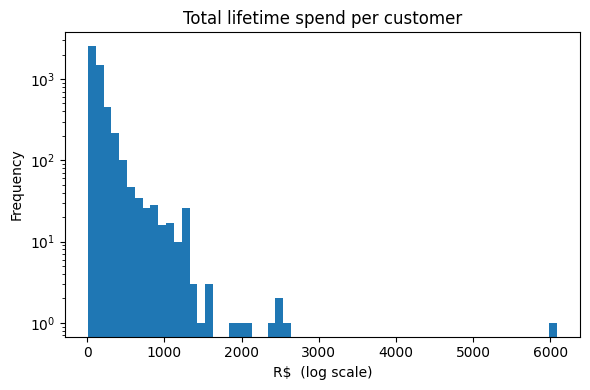

In [7]:
plt.figure(figsize=(6,4))
cust['tot_spend'].plot(kind='hist', bins=60)
plt.yscale('log')
plt.title("Total lifetime spend per customer")
plt.xlabel("R$  (log scale)")
plt.tight_layout()
plt.show()

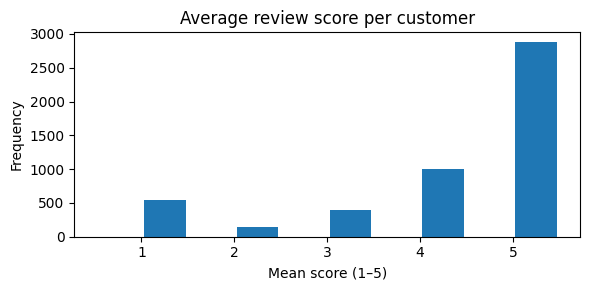

In [8]:
plt.figure(figsize=(6,3))
cust['mean_review'].plot(kind='hist', bins=np.arange(0.5,5.6,0.5), rwidth=0.9)
plt.title("Average review score per customer")
plt.xlabel("Mean score (1–5)")
plt.tight_layout()
plt.show()

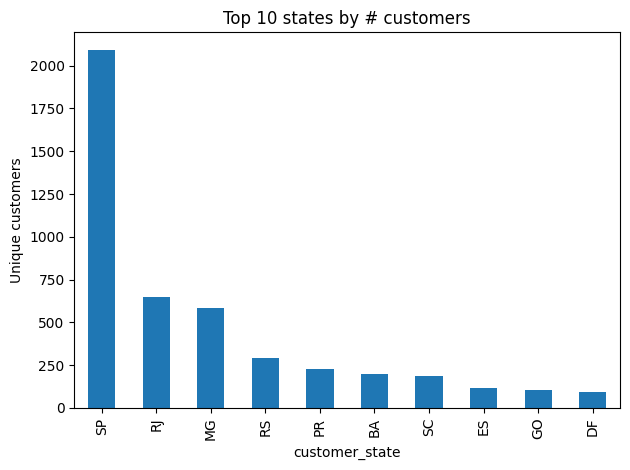

In [9]:
top_states = (cust.groupby('customer_state')['customer_id']
                 .nunique()
                 .sort_values(ascending=False)
                 .head(10))
top_states.plot(kind='bar')
plt.title("Top 10 states by # customers")
plt.ylabel("Unique customers")
plt.tight_layout()
plt.show()

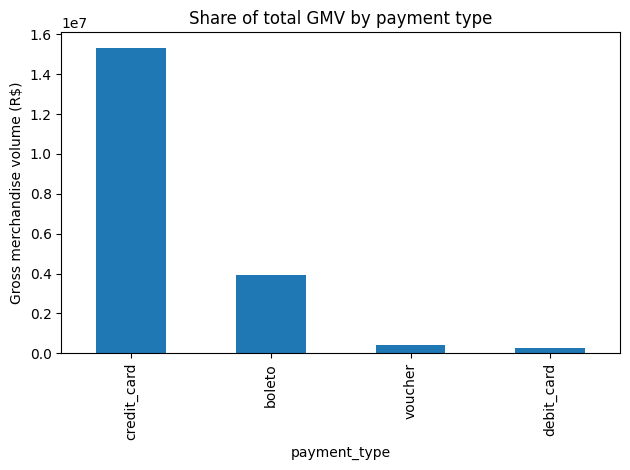

In [10]:
pay_mix = (fact.groupby('payment_type')['payment_value']
                 .sum()
                 .sort_values(ascending=False))
pay_mix.plot(kind='bar')
plt.title("Share of total GMV by payment type")
plt.ylabel("Gross merchandise volume (R$)")
plt.tight_layout()
plt.show()


In [11]:

from sklearn.preprocessing import StandardScaler

num_cols = [
    'n_orders', 'n_items', 'tot_spend', 'avg_item_price',
    'avg_freight', 'avg_basket', 'tenure_days', 'mean_review'
]

X        = cust[num_cols].fillna(0)
scaler   = StandardScaler()
X_scaled = scaler.fit_transform(X)


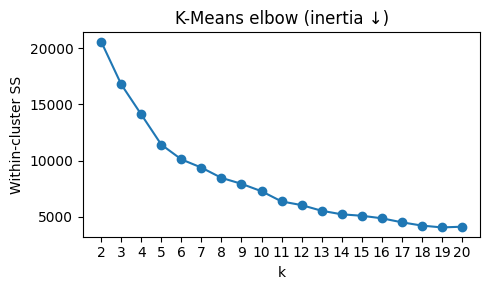

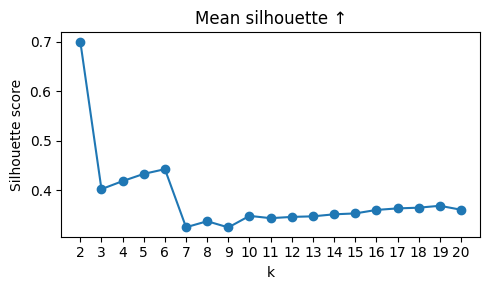

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import numpy as np

k_range   = range(2, 21)
inertias  = []
silh_vals = []

for k in k_range:
    km      = KMeans(n_clusters=k, n_init='auto', random_state=42)
    labels  = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    silh_vals.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(5,3))
plt.plot(k_range, inertias, marker='o')
plt.xticks(k_range)
plt.title("K-Means elbow (inertia ↓)")
plt.xlabel("k");  plt.ylabel("Within-cluster SS")
plt.tight_layout();  plt.show()

plt.figure(figsize=(5,3))
plt.plot(k_range, silh_vals, marker='o')
plt.xticks(k_range)
plt.title("Mean silhouette ↑")
plt.xlabel("k");  plt.ylabel("Silhouette score")
plt.tight_layout();  plt.show()




In [13]:
best_k   = 8
kmeans   = KMeans(n_clusters=best_k, n_init='auto', random_state=42)
km_lbl   = kmeans.fit_predict(X_scaled)

print(f"K-Means (k={best_k})  →  "
      f"silhouette={silhouette_score(X_scaled, km_lbl):.3f}  |  "
      f"Davies-Bouldin={davies_bouldin_score(X_scaled, km_lbl):.3f}  |  "
      f"Calinski-Harabasz={calinski_harabasz_score(X_scaled, km_lbl):.0f}")

K-Means (k=8)  →  silhouette=0.337  |  Davies-Bouldin=0.993  |  Calinski-Harabasz=1814


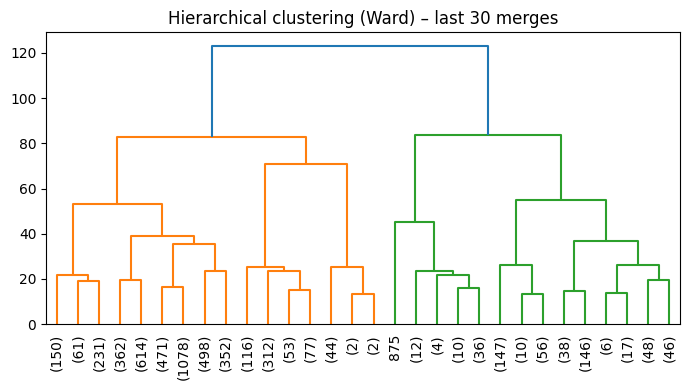

Hierarchical (k=14) →  silhouette=0.303  |  Davies-Bouldin=0.987  |  Calinski-Harabasz=1533


In [14]:

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

Z = linkage(X_scaled, method='ward')

plt.figure(figsize=(7,4))
dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90)
plt.title("Hierarchical clustering (Ward) – last 30 merges")
plt.tight_layout();  plt.show()

n_hier = 14
hier_lbl = fcluster(Z, n_hier, criterion='maxclust')

print(f"Hierarchical (k={n_hier}) →  "
      f"silhouette={silhouette_score(X_scaled, hier_lbl):.3f}  |  "
      f"Davies-Bouldin={davies_bouldin_score(X_scaled, hier_lbl):.3f}  |  "
      f"Calinski-Harabasz={calinski_harabasz_score(X_scaled, hier_lbl):.0f}")


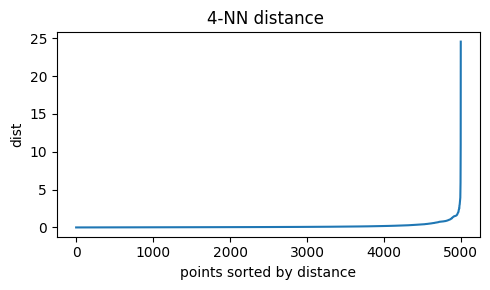

DBSCAN found 10 clusters (+ noise)
silhouette=0.235  |  Davies-Bouldin=1.320  |  Calinski-Harabasz=676


In [15]:

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=4).fit(X_scaled)
dists, _ = nn.kneighbors(X_scaled)
k_dists  = np.sort(dists[:, -1])

plt.figure(figsize=(5,3))
plt.plot(k_dists)
plt.title("4-NN distance ")
plt.ylabel("dist"); plt.xlabel("points sorted by distance")
plt.tight_layout(); plt.show()

db = DBSCAN(eps=0.5, min_samples=15)
db_lbl = db.fit_predict(X_scaled)

n_clusters = len(set(db_lbl)) - (1 if -1 in db_lbl else 0)
print(f"DBSCAN found {n_clusters} clusters (+ noise)")

if n_clusters > 1:
    mask   = db_lbl != -1
    print(f"silhouette={silhouette_score(X_scaled[mask], db_lbl[mask]):.3f}  |  "
          f"Davies-Bouldin={davies_bouldin_score(X_scaled[mask], db_lbl[mask]):.3f}  |  "
          f"Calinski-Harabasz={calinski_harabasz_score(X_scaled[mask], db_lbl[mask]):.0f}")
else:
    print("Internal metrics undefined because DBSCAN collapsed to ≤1 cluster.")


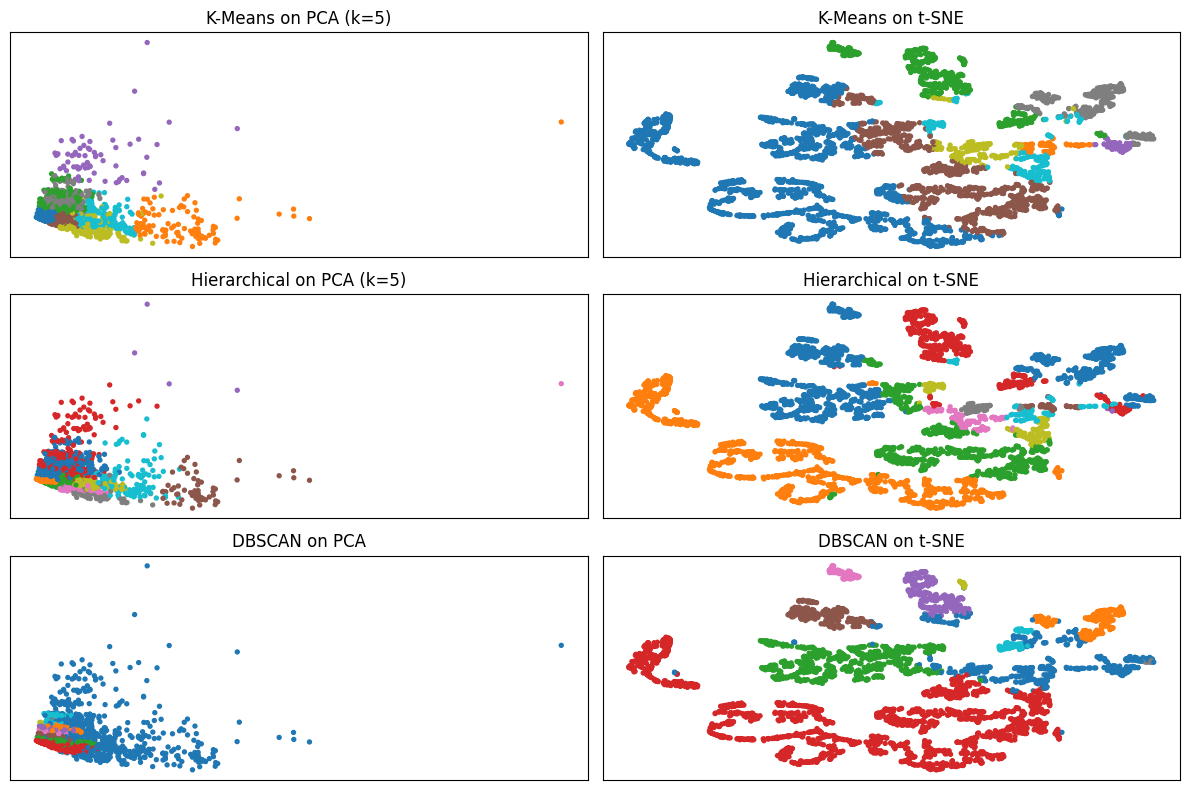

In [16]:

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca_2  = PCA(n_components=2, random_state=42).fit_transform(X_scaled)
tsne_2 = TSNE(n_components=2, init='pca', learning_rate='auto',
              n_iter=1_000, random_state=42).fit_transform(X_scaled)

def scatter_2d(coords, labels, title):
    plt.scatter(coords[:,0], coords[:,1], s=8, c=labels, cmap='tab10')
    plt.title(title)
    plt.xticks([]); plt.yticks([])

plt.figure(figsize=(12,8))

plt.subplot(3,2,1); scatter_2d(pca_2, km_lbl,   "K-Means on PCA (k=5)")
plt.subplot(3,2,2); scatter_2d(tsne_2, km_lbl,  "K-Means on t-SNE")

plt.subplot(3,2,3); scatter_2d(pca_2, hier_lbl, "Hierarchical on PCA (k=5)")
plt.subplot(3,2,4); scatter_2d(tsne_2, hier_lbl,"Hierarchical on t-SNE")

plt.subplot(3,2,5); scatter_2d(pca_2, db_lbl,   "DBSCAN on PCA")
plt.subplot(3,2,6); scatter_2d(tsne_2, db_lbl,  "DBSCAN on t-SNE")

plt.tight_layout();  plt.show()


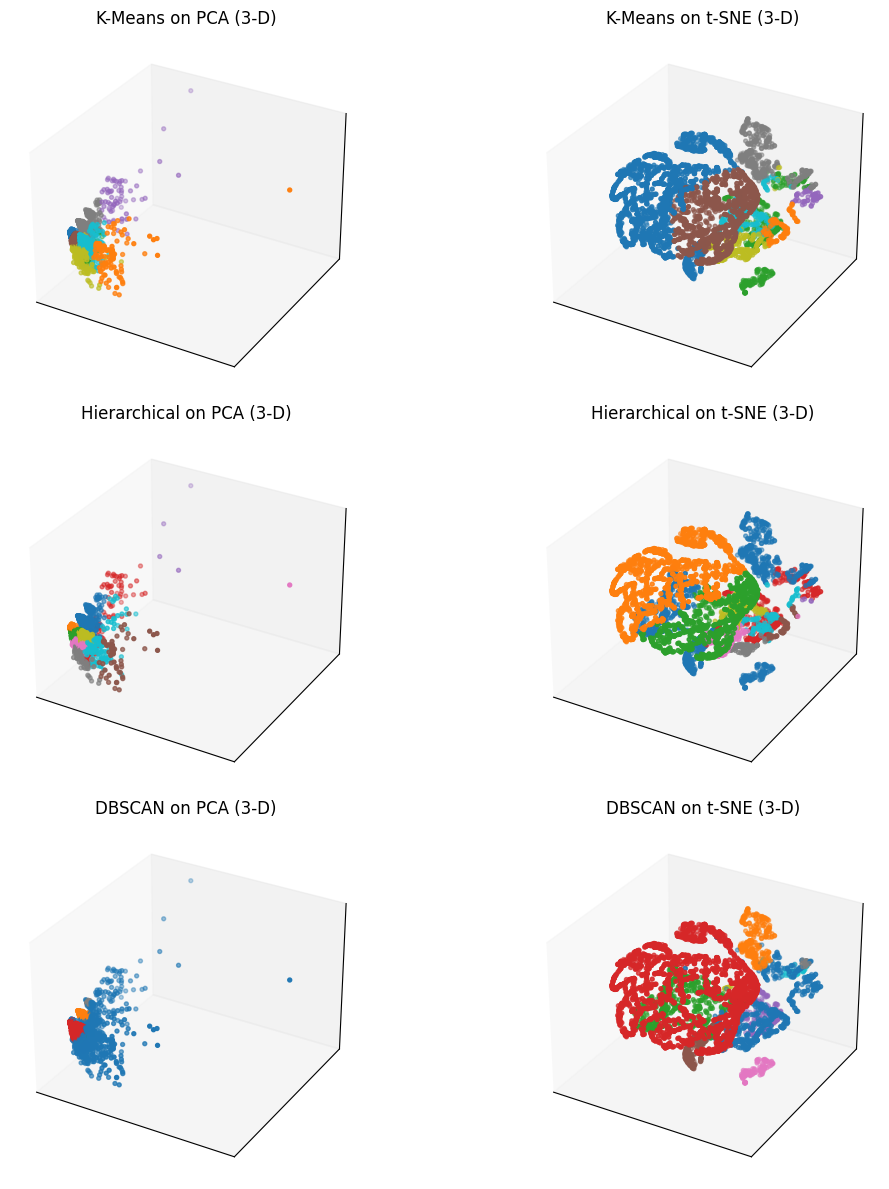

In [17]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

pca_3  = PCA(n_components=3, random_state=42).fit_transform(X_scaled)
tsne_3 = TSNE(n_components=3, init='pca', learning_rate='auto',
              n_iter=1_000, random_state=42).fit_transform(X_scaled)

def scatter_3d(ax, coords, labels, title):
    """Helper to plot a small 3-D scatter with minimal fuss."""
    ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2],
               c=labels, s=8, cmap='tab10', depthshade=True)
    ax.set_title(title, pad=10)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

fig = plt.figure(figsize=(12, 12))

ax1 = fig.add_subplot(3, 2, 1, projection='3d')
scatter_3d(ax1, pca_3,  km_lbl,  "K-Means on PCA (3-D)")
ax2 = fig.add_subplot(3, 2, 2, projection='3d')
scatter_3d(ax2, tsne_3, km_lbl,  "K-Means on t-SNE (3-D)")

ax3 = fig.add_subplot(3, 2, 3, projection='3d')
scatter_3d(ax3, pca_3,  hier_lbl, "Hierarchical on PCA (3-D)")
ax4 = fig.add_subplot(3, 2, 4, projection='3d')
scatter_3d(ax4, tsne_3, hier_lbl, "Hierarchical on t-SNE (3-D)")

ax5 = fig.add_subplot(3, 2, 5, projection='3d')
scatter_3d(ax5, pca_3,  db_lbl,  "DBSCAN on PCA (3-D)")
ax6 = fig.add_subplot(3, 2, 6, projection='3d')
scatter_3d(ax6, tsne_3, db_lbl,  "DBSCAN on t-SNE (3-D)")

fig.tight_layout()
plt.show()


In [18]:
def plot_3d(coords, labels, title, size=3):
    """
    coords : ndarray  (n_samples, 3)
    labels : array-like of ints / strs
    title  : figure title
    size   : marker size
    """
    df = pd.DataFrame(coords, columns=["x", "y", "z"])
    df["cluster"] = labels.astype(str)
    fig = px.scatter_3d(
        df, x="x", y="y", z="z",
        color="cluster",
        opacity=0.75,
        title=title,
        hover_data={"cluster": True},
    )
    fig.update_traces(marker=dict(size=size))
    fig.show()

plot_3d(pca_3,  km_lbl,   "K-Means (k=5) on PCA-3D")
plot_3d(tsne_3, km_lbl,   "K-Means (k=5) on t-SNE-3D")

plot_3d(pca_3,  hier_lbl, "Hierarchical (k=5) on PCA-3D")
plot_3d(tsne_3, hier_lbl, "Hierarchical (k=5) on t-SNE-3D")

plot_3d(pca_3,  db_lbl,   "DBSCAN on PCA-3D")
plot_3d(tsne_3, db_lbl,   "DBSCAN on t-SNE-3D")


In [19]:
def _score(X, labels, name):
    """Helper → compute three internal metrics and print one line."""
    if len(set(labels)) < 2:
        print(f"{name:<35}  →  < 2 clusters – metrics n/a")
        return
    sil  = silhouette_score(X, labels)
    db   = davies_bouldin_score(X, labels)
    ch   = calinski_harabasz_score(X, labels)
    print(f"{name:<35}  →  silhouette={sil:.3f} | DB={db:.3f} | CH={ch:,.0f}")

In [20]:
X_mm = MinMaxScaler().fit_transform(cust[num_cols].fillna(0))

km_mm     = KMeans(n_clusters=5, n_init='auto', random_state=42).fit(X_mm)
_score(X_mm, km_mm.labels_, "K-Means (k=5)  + MinMax scaling")

K-Means (k=5)  + MinMax scaling      →  silhouette=0.454 | DB=0.893 | CH=3,959


In [21]:
agg_cos = AgglomerativeClustering(
            n_clusters=5,
            linkage='average',
            affinity='cosine'
         ).fit(X_scaled)
_score(X_scaled, agg_cos.labels_, "Agglomerative (average, cosine)")

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning:

Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead



Agglomerative (average, cosine)      →  silhouette=0.348 | DB=1.302 | CH=924


In [22]:
umap_5 = umap.UMAP(n_components=5, metric='cosine', random_state=42) \
             .fit_transform(X_scaled)

km_umap = KMeans(n_clusters=5, n_init='auto', random_state=42).fit(umap_5)
_score(umap_5, km_umap.labels_, "K-Means (k=5) on UMAP-5D")

df_umap = pd.DataFrame(umap_5[:, :3], columns=['u1','u2','u3'])
df_umap['cluster'] = km_umap.labels_.astype(str)
fig = px.scatter_3d(df_umap, x='u1', y='u2', z='u3',
                    color='cluster', opacity=0.8,
                    title="UMAP (first 3 dims) coloured by K-Means")
fig.show()


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



K-Means (k=5) on UMAP-5D             →  silhouette=0.545 | DB=0.750 | CH=3,837


In [23]:
cust['cluster'] = km_lbl

In [24]:
fact_cl = fact.merge(cust[['customer_id', 'cluster']], on='customer_id', how='left')

fav_cat = (
    fact_cl
      .groupby(['cluster', 'product_category_name'])
      .size()
      .sort_values(ascending=False)
      .groupby(level=0)
      .head(3)         
      .reset_index(name='purchases')
)
fav_cat['rank'] = fav_cat.groupby('cluster').cumcount() 
cat_wide = fav_cat.pivot_table(index='cluster',
                               columns='rank',
                               values='product_category_name',
                               aggfunc='first')
cat_wide.columns = ['fav_cat_1', 'fav_cat_2', 'fav_cat_3']

In [25]:
stats = (
    cust.groupby('cluster').agg(
        customers        = ('customer_id',  'nunique'),
        lifetime_spend   = ('tot_spend',    'mean'),
        avg_basket       = ('avg_basket',   'mean'),
        orders_per_cust  = ('n_orders',     'mean'),
        mean_review      = ('mean_review',  'mean'),
        top_state        = ('customer_state',
                            lambda s: s.value_counts().idxmax()),
        top_city         = ('customer_city',
                            lambda s: s.value_counts().idxmax()),
    )
    .round(2)
)

profile = stats.join(cat_wide)

In [26]:
def label_row(r):
    if r['avg_basket'] > 300 and r['mean_review'] >= 4.5:
        return "Premium power shoppers"
    elif r['avg_basket'] < 60 and r['mean_review'] < 3.8:
        return "Price-sensitive sceptics"
    elif r['orders_per_cust'] >= 5:
        return "Loyal mid-spenders"
    elif r['lifetime_spend'] > 1000:
        return "High-value occasionals"
    else:
        return "Regulars"

profile['segment_label'] = profile.apply(label_row, axis=1)

In [27]:
def recs(row):
    seg = row['segment_label']
    if seg == "Premium power shoppers":
        return [
            "Offer early-access flash sales on their favourite categories.",
            "Free express shipping-upgrade to strengthen loyalty."
        ]
    if seg == "Price-sensitive sceptics":
        return [
            "Push limited-time discounts / bundle deals.",
            "Highlight hassle-free returns to build trust."
        ]
    if seg == "Loyal mid-spenders":
        return [
            "Launch a tiered loyalty perk (e.g. birthday coupon).",
            "Cross-sell complementary products in checkout."
        ]
    if seg == "High-value occasionals":
        return [
            "Send personalised reactivation emails 30 days post-purchase.",
            "Extend VIP chat support to nudge repeat orders."
        ]
    return [
        "Seasonal newsletter with new arrivals.",
        "Geo-targeted shipping incentive ({} ↔ {} hotspot)".format(
            row['top_city'], row['top_state'])
    ]

profile['recommendations'] = profile.apply(recs, axis=1)


In [28]:
profile

,customers,lifetime_spend,avg_basket,orders_per_cust,mean_review,top_state,top_city,fav_cat_1,fav_cat_2,fav_cat_3,segment_label,recommendations
cluster,,,,,,,,,,,,
0.0,2228,70.12,70.12,1.0,4.58,SP,sao paulo,bed_bath_table,health_beauty,sports_leisure,Regulars,"[Seasonal newsletter with new arrivals., Geo-t..."
1.0,110,1172.21,1172.21,1.0,3.77,SP,sao paulo,watches_gifts,health_beauty,agro_industry_and_commerce,High-value occasionals,[Send personalised reactivation emails 30 days...
2.0,613,120.77,120.77,1.0,1.21,SP,sao paulo,bed_bath_table,furniture_decor,computers_accessories,Regulars,"[Seasonal newsletter with new arrivals., Geo-t..."
3.0,67,531.90,531.90,1.0,3.38,SP,sao paulo,housewares,bed_bath_table,furniture_decor,Regulars,"[Seasonal newsletter with new arrivals., Geo-t..."
4.0,1104,169.20,169.20,1.0,4.60,SP,sao paulo,sports_leisure,bed_bath_table,watches_gifts,Regulars,"[Seasonal newsletter with new arrivals., Geo-t..."
5.0,409,181.56,181.56,1.0,4.55,SP,sao paulo,bed_bath_table,furniture_decor,sports_leisure,Regulars,"[Seasonal newsletter with new arrivals., Geo-t..."
6.0,201,270.04,270.04,1.0,4.14,SP,rio de janeiro,housewares,furniture_decor,office_furniture,Regulars,"[Seasonal newsletter with new arrivals., Geo-t..."
7.0,268,443.65,443.65,1.0,4.27,SP,sao paulo,health_beauty,watches_gifts,perfumery,Regulars,"[Seasonal newsletter with new arrivals., Geo-t..."


In [29]:
pd.set_option("display.max_colwidth", None)
display_cols = ['segment_label', 'customers', 'avg_basket',
                'mean_review', 'fav_cat_1', 'fav_cat_2', 'fav_cat_3',
                'top_state', 'top_city', 'recommendations']
profile[display_cols]


,segment_label,customers,avg_basket,mean_review,fav_cat_1,fav_cat_2,fav_cat_3,top_state,top_city,recommendations
cluster,,,,,,,,,,
0.0,Regulars,2228,70.12,4.58,bed_bath_table,health_beauty,sports_leisure,SP,sao paulo,"[Seasonal newsletter with new arrivals., Geo-targeted shipping incentive (sao paulo ↔ SP hotspot)]"
1.0,High-value occasionals,110,1172.21,3.77,watches_gifts,health_beauty,agro_industry_and_commerce,SP,sao paulo,"[Send personalised reactivation emails 30 days post-purchase., Extend VIP chat support to nudge repeat orders.]"
2.0,Regulars,613,120.77,1.21,bed_bath_table,furniture_decor,computers_accessories,SP,sao paulo,"[Seasonal newsletter with new arrivals., Geo-targeted shipping incentive (sao paulo ↔ SP hotspot)]"
3.0,Regulars,67,531.90,3.38,housewares,bed_bath_table,furniture_decor,SP,sao paulo,"[Seasonal newsletter with new arrivals., Geo-targeted shipping incentive (sao paulo ↔ SP hotspot)]"
4.0,Regulars,1104,169.20,4.60,sports_leisure,bed_bath_table,watches_gifts,SP,sao paulo,"[Seasonal newsletter with new arrivals., Geo-targeted shipping incentive (sao paulo ↔ SP hotspot)]"
5.0,Regulars,409,181.56,4.55,bed_bath_table,furniture_decor,sports_leisure,SP,sao paulo,"[Seasonal newsletter with new arrivals., Geo-targeted shipping incentive (sao paulo ↔ SP hotspot)]"
6.0,Regulars,201,270.04,4.14,housewares,furniture_decor,office_furniture,SP,rio de janeiro,"[Seasonal newsletter with new arrivals., Geo-targeted shipping incentive (rio de janeiro ↔ SP hotspot)]"
7.0,Regulars,268,443.65,4.27,health_beauty,watches_gifts,perfumery,SP,sao paulo,"[Seasonal newsletter with new arrivals., Geo-targeted shipping incentive (sao paulo ↔ SP hotspot)]"


In [35]:
cust['segment_label'] = profile['segment_label']

In [36]:
cust

,customer_id,n_orders,n_items,first_purchase,last_purchase,tot_spend,avg_item_price,avg_freight,mean_review,tenure_days,...,customer_city,customer_state,customer_zip_code_prefix,cluster,months_active,order_cadence,loyalty_value,spend_per_item,avg_sentiment,segment_label
0,c6e3f283e7657e8d92765c2ae986e1a9,1,2,2018-04-12 20:24:50,2018-04-12 20:24:50,107.76,45.00,8.88,5.0,1,...,sao paulo,SP,5128,5,1.0,1.0,5.0,53.88,0.0000,Regulars
1,c89efa354fe04de70beef217caee4cf8,1,1,2018-03-12 21:27:49,2018-03-12 21:27:49,474.97,429.90,45.07,1.0,1,...,fortaleza,CE,60192,7,1.0,1.0,1.0,474.97,0.0000,High-value occasionals
2,4568b6ca77fd9f28ed5ba06a4a8f2e6a,1,1,2018-04-13 19:45:22,2018-04-13 19:45:22,92.50,64.99,27.51,4.0,1,...,rio de janeiro,RJ,20021,4,1.0,1.0,4.0,92.50,0.0000,Regulars
3,b56dedcb8516771d10b5378e7957a31f,1,1,2017-05-08 18:53:03,2017-05-08 18:53:03,57.77,49.99,7.78,5.0,1,...,sao paulo,SP,8041,0,1.0,1.0,5.0,57.77,0.0000,Regulars
4,92015b6a20c9ca16333a0907090e452a,1,1,2017-07-30 00:58:52,2017-07-30 00:58:52,42.92,25.00,17.92,4.0,1,...,feira de santana,BA,44003,0,1.0,1.0,4.0,42.92,-0.4019,Regulars
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,eb4201ee621ab44ff61deab8ce0e2ee9,1,2,2018-04-18 20:58:55,2018-04-18 20:58:55,112.44,36.90,19.32,5.0,1,...,guaiba,RS,92500,5,1.0,1.0,5.0,56.22,0.0000,NaN
4996,fb2a5ffc3d8318211cf1c878d8ef3013,1,1,2017-08-18 09:35:01,2017-08-18 09:35:01,68.13,48.90,19.23,5.0,1,...,carapicuiba,SP,6385,0,1.0,1.0,5.0,68.13,0.0000,NaN
4997,b591ec51348a19a15a433d07865cefe7,1,1,2018-06-06 20:16:16,2018-06-06 20:16:16,48.13,29.90,18.23,5.0,1,...,lucianopolis,SP,17475,0,1.0,1.0,5.0,48.13,0.0000,NaN
4998,898b7fee99c4e42170ab69ba59be0a8b,1,1,2018-08-29 15:00:37,2018-08-29 15:00:37,93.75,84.99,8.76,5.0,1,...,limeira,SP,13483,0,1.0,1.0,5.0,93.75,0.0000,NaN


In [30]:
sia = SentimentIntensityAnalyzer()

def _clean(txt):
    return re.sub(r'\s+', ' ', str(txt)).strip().lower()

reviews['sentiment'] = reviews['review_comment_message'].fillna('') \
                            .apply(_clean) \
                            .apply(lambda t: sia.polarity_scores(t)['compound'])

cust_sent = (
    reviews.merge(orders[['order_id','customer_id']], on='order_id', how='left')
           .groupby('customer_id')['sentiment']
           .mean()
           .rename('avg_sentiment')
)

In [31]:
cust['months_active'] = np.maximum(cust['tenure_days'] / 30.0, 1)
cust['order_cadence'] = cust['n_orders'] / cust['months_active']

cust['loyalty_value'] = cust['mean_review'] * cust['order_cadence']

cust['spend_per_item'] = cust['tot_spend'] / cust['n_items'].clip(lower=1)

In [41]:

pivot = (
    fact_with_ori
        .groupby(['cluster','origin'])['order_id']
        .nunique()                                    # ≈ orders per channel
        .unstack(fill_value=0)
)

pivot_pct = (pivot.T / pivot.sum(axis=1) * 100).T.round(1)  # % by segment

import plotly.express as px

fig = px.bar(
    pivot_pct.reset_index(),
    x='cluster', y=pivot_pct.columns,
    title="Acquisition-channel mix by customer segment",
    labels={'value':'% of orders', 'cluster':'Segment'},
    text_auto=True
)
fig.update_layout(barmode='stack', legend_title="Origin channel")
fig.show()

summary = (
    pivot_pct
      .assign(most_used=lambda d: d.idxmax(axis=1))
      .join(cust.groupby('cluster')['segment_label'].first())
      .rename_axis('cluster')
      .reset_index()
      .loc[:, ['cluster','segment_label','most_used'] + list(pivot_pct.columns)]
)

display(summary)


,cluster,segment_label,most_used,direct_traffic,display,email,organic_search,other,paid_search,referral,social,unknown
0,0.0,Regulars,unknown,0.3,0.0,0.0,1.0,0.1,1.6,0.1,0.3,96.5
1,1.0,None,unknown,0.0,0.0,0.9,1.8,0.0,0.0,0.0,2.7,94.5
2,2.0,Regulars,unknown,0.0,0.0,0.0,0.5,0.3,1.0,0.2,0.2,97.9
3,3.0,None,unknown,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0
4,4.0,Regulars,unknown,0.2,0.1,0.0,0.8,0.2,0.9,0.2,0.2,97.5
5,5.0,Regulars,unknown,0.0,0.0,0.0,1.9,0.0,1.5,0.2,1.0,95.4
6,6.0,None,unknown,0.0,0.5,0.0,1.0,0.0,2.0,0.0,0.0,96.5
7,7.0,High-value occasionals,unknown,0.0,0.0,0.0,1.1,0.4,0.7,0.0,0.0,97.8


In [42]:
from sklearn.preprocessing   import StandardScaler
from sklearn.mixture         import GaussianMixture
from sklearn.metrics         import silhouette_score, adjusted_rand_score
import numpy as np, pandas as pd


In [43]:
def build_cust_year(year):
    """Return customer-features for orders whose purchase date is in <year>."""
    mask = fact['order_purchase_timestamp'].dt.year == year
    fy   = fact.loc[mask]

    cust_y = (
        fy.groupby('customer_id')
          .agg(
              n_orders      = ('order_id',  'nunique'),
              n_items       = ('order_item_id', 'count'),
              tot_spend     = (lambda s: fy.loc[s.index, 'price'].sum()
                                            + fy.loc[s.index, 'freight_value'].sum()),
              avg_basket    = (lambda s: fy.loc[s.index, 'price'].sum()
                                            / fy.loc[s.index, 'order_id'].nunique()),
              mean_review   = ('review_score', 'mean'),
              first_date    = ('order_purchase_timestamp', 'min'),
              last_date     = ('order_purchase_timestamp',  'max')
          )
          .reset_index()
    )
    cust_y['tenure_days']  = (cust_y['last_date'] - cust_y['first_date']).dt.days + 1
    cust_y['order_cadence']= cust_y['n_orders'] / np.maximum(cust_y['tenure_days']/30, 1)
    return cust_y.drop(columns=['first_date','last_date'])
    

In [46]:
def build_cust_year(year):
    """Return customer features computed from orders whose PURCHASE date is in <year>."""
    fy = fact[fact['order_purchase_timestamp'].dt.year == year].copy()

    fy['line_total'] = fy['price'].astype(float) + fy['freight_value'].astype(float)

    cust_y = (
        fy.groupby('customer_id')
          .agg(
              n_orders     = ('order_id',            'nunique'),
              n_items      = ('order_item_id',       'count'),
              tot_spend    = ('line_total',          'sum'),
              mean_review  = ('review_score',        'mean'),
              first_date   = ('order_purchase_timestamp', 'min'),
              last_date    = ('order_purchase_timestamp', 'max'),
          )
          .reset_index()
    )

    cust_y['avg_basket']    = cust_y['tot_spend'] / cust_y['n_orders']
    cust_y['tenure_days']   = (cust_y['last_date'] - cust_y['first_date']).dt.days + 1
    cust_y['order_cadence'] = cust_y['n_orders'] / np.maximum(cust_y['tenure_days'] / 30, 1)

    return cust_y.drop(columns=['first_date', 'last_date'])


In [47]:
cust17 = build_cust_year(2017)
cust18 = build_cust_year(2018)

num_cols = [c for c in cust17.columns if c != 'customer_id']

X17 = cust17[num_cols].fillna(0).values
X18 = cust18[num_cols].fillna(0).values

scaler = StandardScaler().fit(X17)
X17z   = scaler.transform(X17)
X18z   = scaler.transform(X18)


In [48]:
k = 5
gmm = GaussianMixture(n_components=k, covariance_type='full',
                      n_init=5, random_state=42)
gmm.fit(X17z)

lbl17 = gmm.predict(X17z)
sil17 = silhouette_score(X17z, lbl17)

print(f"GMM-2017  k={k}  →  silhouette={sil17:.3f}  |  BIC={gmm.bic(X17z):,.0f}")


GMM-2017  k=5  →  silhouette=0.411  |  BIC=-2,374,480


In [49]:
lbl18 = gmm.predict(X18z)
sil18 = silhouette_score(X18z, lbl18)

print(f"2018 data scored by 2017 model → silhouette={sil18:.3f}")

2018 data scored by 2017 model → silhouette=0.424


In [50]:
common_ids = np.intersect1d(cust17['customer_id'], cust18['customer_id'])
map17 = dict(zip(cust17['customer_id'], lbl17))
map18 = dict(zip(cust18['customer_id'], lbl18))

y_true = [map17[c] for c in common_ids]
y_pred = [map18[c] for c in common_ids]

ari = adjusted_rand_score(y_true, y_pred)
print(f"Adjusted Rand Index (customers appearing in both years) = {ari:.3f}")


Adjusted Rand Index (customers appearing in both years) = 1.000


In [51]:
sz17 = pd.Series(lbl17).value_counts(normalize=True).sort_index()
sz18 = pd.Series(lbl18).value_counts(normalize=True).sort_index()
drift = pd.concat([sz17, sz18], axis=1, keys=['2017','2018']).fillna(0).round(3)
display(drift.style.format('{:.1%}').set_caption("Cluster share drift"))


,2017,2018
0,8.4%,7.5%
1,75.9%,76.4%
2,4.6%,4.1%
3,10.0%,10.9%
4,1.2%,1.1%


In [54]:
pip install scikit-uplift


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 1.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [55]:
import pandas as pd, numpy as np
from datetime import timedelta
from sklearn.preprocessing   import StandardScaler, OneHotEncoder
from sklearn.compose         import ColumnTransformer
from sklearn.pipeline        import Pipeline
from sklift.models           import TwoModels
from sklift.metrics          import uplift_at_k, qini_auc_score
from sklearn.linear_model    import LogisticRegression
from sklearn.ensemble        import RandomForestClassifier


In [64]:
if 'cluster' not in cust.columns:
    pass

fact = fact.merge(cust[['customer_id', 'cluster',
                        'avg_basket', 'mean_review',
                        'order_cadence', 'tot_spend']],
                  on='customer_id', how='left')

fact['cluster'].fillna(-1, inplace=True)
fact['cluster'] = fact['cluster'].astype(int)


/tmp/ipykernel_35/2047517515.py:13: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [ ]:
cust = (
    fact
      .groupby('customer_id')
      .agg(
          n_orders   = ('order_id',  'nunique'),
          n_items    = ('order_item_id', 'count'),
          tot_spend  = (lambda s: fact.loc[s.index, 'price'].astype(float).sum()
                                   + fact.loc[s.index, 'freight_value'].astype(float).sum()),
          mean_review= ('review_score', 'mean')
      )
      .assign(
          avg_basket = lambda d: d['tot_spend'] / d['n_orders'],
          order_cadence = lambda d: d['n_orders'] / 
                          (1 + (fact.groupby('customer_id')['order_purchase_timestamp']
                                         .apply(lambda x: (x.max() - x.min()).days)))
      )
      .reset_index()
)

from sklearn.preprocessing import StandardScaler
from sklearn.cluster        import KMeans

X      = cust[['n_orders','tot_spend','avg_basket','order_cadence']].fillna(0)
Xz     = StandardScaler().fit_transform(X)
cust['cluster'] = KMeans(n_clusters=5, n_init='auto', random_state=42).fit_predict(Xz)


In [56]:
fact['treatment'] = (fact['freight_value'] == 0).astype(int)

fact = fact.sort_values(['customer_id', 'order_purchase_timestamp'])
fact['next_order_date'] = fact.groupby('customer_id')['order_purchase_timestamp'].shift(-1)
fact['days_to_next']    = (fact['next_order_date'] - fact['order_purchase_timestamp']).dt.days
fact['outcome']         = (fact['days_to_next'].between(1, 60)).astype(int)

model_df = (
    fact
      .merge(cust[['customer_id','cluster','avg_basket','mean_review',
                   'order_cadence','tot_spend']], on='customer_id', how='left')
      .dropna(subset=['outcome'])                         # keep rows we can evaluate
)

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in greater_equal

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in less_equal



In [67]:
cust

,customer_id,n_orders,n_items,first_purchase,last_purchase,tot_spend,avg_item_price,avg_freight,mean_review,tenure_days,...,customer_city,customer_state,customer_zip_code_prefix,cluster,months_active,order_cadence,loyalty_value,spend_per_item,avg_sentiment,segment_label
0,c6e3f283e7657e8d92765c2ae986e1a9,1,2,2018-04-12 20:24:50,2018-04-12 20:24:50,107.76,45.00,8.88,5.0,1,...,sao paulo,SP,5128,5,1.0,1.0,5.0,53.88,0.0000,Regulars
1,c89efa354fe04de70beef217caee4cf8,1,1,2018-03-12 21:27:49,2018-03-12 21:27:49,474.97,429.90,45.07,1.0,1,...,fortaleza,CE,60192,7,1.0,1.0,1.0,474.97,0.0000,High-value occasionals
2,4568b6ca77fd9f28ed5ba06a4a8f2e6a,1,1,2018-04-13 19:45:22,2018-04-13 19:45:22,92.50,64.99,27.51,4.0,1,...,rio de janeiro,RJ,20021,4,1.0,1.0,4.0,92.50,0.0000,Regulars
3,b56dedcb8516771d10b5378e7957a31f,1,1,2017-05-08 18:53:03,2017-05-08 18:53:03,57.77,49.99,7.78,5.0,1,...,sao paulo,SP,8041,0,1.0,1.0,5.0,57.77,0.0000,Regulars
4,92015b6a20c9ca16333a0907090e452a,1,1,2017-07-30 00:58:52,2017-07-30 00:58:52,42.92,25.00,17.92,4.0,1,...,feira de santana,BA,44003,0,1.0,1.0,4.0,42.92,-0.4019,Regulars
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,eb4201ee621ab44ff61deab8ce0e2ee9,1,2,2018-04-18 20:58:55,2018-04-18 20:58:55,112.44,36.90,19.32,5.0,1,...,guaiba,RS,92500,5,1.0,1.0,5.0,56.22,0.0000,NaN
4996,fb2a5ffc3d8318211cf1c878d8ef3013,1,1,2017-08-18 09:35:01,2017-08-18 09:35:01,68.13,48.90,19.23,5.0,1,...,carapicuiba,SP,6385,0,1.0,1.0,5.0,68.13,0.0000,NaN
4997,b591ec51348a19a15a433d07865cefe7,1,1,2018-06-06 20:16:16,2018-06-06 20:16:16,48.13,29.90,18.23,5.0,1,...,lucianopolis,SP,17475,0,1.0,1.0,5.0,48.13,0.0000,NaN
4998,898b7fee99c4e42170ab69ba59be0a8b,1,1,2018-08-29 15:00:37,2018-08-29 15:00:37,93.75,84.99,8.76,5.0,1,...,limeira,SP,13483,0,1.0,1.0,5.0,93.75,0.0000,NaN


In [69]:
cust

,customer_id,n_orders,n_items,first_purchase,last_purchase,tot_spend,avg_item_price,avg_freight,mean_review,tenure_days,...,customer_city,customer_state,customer_zip_code_prefix,cluster,months_active,order_cadence,loyalty_value,spend_per_item,avg_sentiment,segment_label
0,c6e3f283e7657e8d92765c2ae986e1a9,1,2,2018-04-12 20:24:50,2018-04-12 20:24:50,107.76,45.00,8.88,5.0,1,...,sao paulo,SP,5128,5,1.0,1.0,5.0,53.88,0.0000,Regulars
1,c89efa354fe04de70beef217caee4cf8,1,1,2018-03-12 21:27:49,2018-03-12 21:27:49,474.97,429.90,45.07,1.0,1,...,fortaleza,CE,60192,7,1.0,1.0,1.0,474.97,0.0000,High-value occasionals
2,4568b6ca77fd9f28ed5ba06a4a8f2e6a,1,1,2018-04-13 19:45:22,2018-04-13 19:45:22,92.50,64.99,27.51,4.0,1,...,rio de janeiro,RJ,20021,4,1.0,1.0,4.0,92.50,0.0000,Regulars
3,b56dedcb8516771d10b5378e7957a31f,1,1,2017-05-08 18:53:03,2017-05-08 18:53:03,57.77,49.99,7.78,5.0,1,...,sao paulo,SP,8041,0,1.0,1.0,5.0,57.77,0.0000,Regulars
4,92015b6a20c9ca16333a0907090e452a,1,1,2017-07-30 00:58:52,2017-07-30 00:58:52,42.92,25.00,17.92,4.0,1,...,feira de santana,BA,44003,0,1.0,1.0,4.0,42.92,-0.4019,Regulars
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,eb4201ee621ab44ff61deab8ce0e2ee9,1,2,2018-04-18 20:58:55,2018-04-18 20:58:55,112.44,36.90,19.32,5.0,1,...,guaiba,RS,92500,5,1.0,1.0,5.0,56.22,0.0000,NaN
4996,fb2a5ffc3d8318211cf1c878d8ef3013,1,1,2017-08-18 09:35:01,2017-08-18 09:35:01,68.13,48.90,19.23,5.0,1,...,carapicuiba,SP,6385,0,1.0,1.0,5.0,68.13,0.0000,NaN
4997,b591ec51348a19a15a433d07865cefe7,1,1,2018-06-06 20:16:16,2018-06-06 20:16:16,48.13,29.90,18.23,5.0,1,...,lucianopolis,SP,17475,0,1.0,1.0,5.0,48.13,0.0000,NaN
4998,898b7fee99c4e42170ab69ba59be0a8b,1,1,2018-08-29 15:00:37,2018-08-29 15:00:37,93.75,84.99,8.76,5.0,1,...,limeira,SP,13483,0,1.0,1.0,5.0,93.75,0.0000,NaN


In [75]:
fact_small

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,...,cluster_x,avg_basket_x,mean_review_x,order_cadence_x,tot_spend_x,cluster_y,avg_basket_y,mean_review_y,order_cadence_y,tot_spend_y
0,bc3e295306ee4d3eba91aca49b0bb539,1,bae1013381fa74d68d18c89d313f97eb,bb135baca94c82fcb731335ad5b04a03,2017-10-18 08:56:17,15.00,7.78,000bf8121c3412d3057d32371c5d3395,delivered,2017-10-11 07:44:31,...,5,45.56,5.0,1.0,45.56,5,45.56,5.0,1.0,45.56
1,bc3e295306ee4d3eba91aca49b0bb539,2,bae1013381fa74d68d18c89d313f97eb,bb135baca94c82fcb731335ad5b04a03,2017-10-18 08:56:17,15.00,7.78,000bf8121c3412d3057d32371c5d3395,delivered,2017-10-11 07:44:31,...,5,45.56,5.0,1.0,45.56,5,45.56,5.0,1.0,45.56
2,4ed7a5d31f58c9c3b20a61e3927db6d9,1,d03bd02af9fff4b98f1c972315e5e9ef,0241d4d5d36f10f80c644447315af0bd,2018-05-13 21:11:37,79.90,12.70,0013cd8e350a7cc76873441e431dd5ee,delivered,2018-05-07 23:25:09,...,0,92.60,5.0,1.0,92.60,0,92.60,5.0,1.0,92.60
3,7ad292313f72d59700c72169ba543021,1,329851bd191cfd30470ffd5aa5457c23,dbc22125167c298ef99da25668e1011f,2017-10-02 14:14:19,37.90,13.37,0018f7fde63ca77254dbc47f4ea358b2,delivered,2017-09-26 14:01:47,...,0,51.27,5.0,1.0,51.27,0,51.27,5.0,1.0,51.27
4,e531f04ac27aac6bf0cba03986415776,1,685919d3ededc26c0ec078b32241025a,855668e0971d4dfd7bef1b6a4133b41b,2018-04-19 02:15:26,52.00,22.94,0028ff36263a86bf679df7c863a0a0ba,delivered,2018-04-12 17:16:49,...,2,74.94,1.0,1.0,74.94,2,74.94,1.0,1.0,74.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5996,5d9fde36e9b14f9c646577bb073b1486,1,437c05a395e9e47f9762e677a7068ce7,bf84056e679dbe9c69929847a40e338f,2018-02-28 02:10:26,46.33,7.78,ffed5d4f6245fe13cd57054621eec36a,delivered,2018-02-21 17:27:58,...,5,108.22,5.0,1.0,108.22,5,108.22,5.0,1.0,108.22
5997,5d9fde36e9b14f9c646577bb073b1486,2,437c05a395e9e47f9762e677a7068ce7,bf84056e679dbe9c69929847a40e338f,2018-02-28 02:10:26,46.33,7.78,ffed5d4f6245fe13cd57054621eec36a,delivered,2018-02-21 17:27:58,...,5,108.22,5.0,1.0,108.22,5,108.22,5.0,1.0,108.22
5998,f64b1037e9e9b824414ca423e452b1d0,1,bd588795ddfe953f64d59d514ba0527a,6560211a19b47992c3666cc44a7e94c0,2018-02-23 10:08:06,69.00,14.23,fff3a5c6d542d52b05f7e4518adf996e,delivered,2018-02-18 21:48:22,...,5,249.69,5.0,1.0,249.69,5,249.69,5.0,1.0,249.69
5999,f64b1037e9e9b824414ca423e452b1d0,1,bd588795ddfe953f64d59d514ba0527a,6560211a19b47992c3666cc44a7e94c0,2018-02-23 10:08:06,69.00,14.23,fff3a5c6d542d52b05f7e4518adf996e,delivered,2018-02-18 21:48:22,...,5,249.69,5.0,1.0,249.69,5,249.69,5.0,1.0,249.69


In [84]:
fact_small = fact.copy()

SAMPLED_IDS = set(cust['customer_id'])
fact_small = fact_small[fact_small['customer_id'].isin(SAMPLED_IDS)].copy()

cols_from_cust = [
    'customer_id', 
    'cluster',              
    'avg_basket', 'mean_review',
    'order_cadence', 'tot_spend', ]

fact_small = (
    fact_small
      .merge(cust[cols_from_cust], on='customer_id', how='left', validate='m:1')
)
fact_small['cluster'] = fact_small['cluster_x']
fact_small['avg_basket'] = fact_small['avg_basket_x']
fact_small['mean_review'] = fact_small['mean_review_x']
fact_small['order_cadence'] = fact_small['order_cadence_x']
fact_small['tot_spend'] = fact_small['tot_spend_x']

In [85]:
print(f"fact_small rows      : {len(fact_small):,}")
print(" any NA in cluster?  :", fact_small['cluster'].isna().sum())
print(" sample preview      :")
display(fact_small.head(3))
fact_small['treatment'] = (fact_small['freight_value'] == 0).astype(int)

fact_small = fact_small.sort_values(['customer_id', 'order_purchase_timestamp'])
fact_small['next_order_date'] = (
    fact_small.groupby('customer_id')['order_purchase_timestamp'].shift(-1)
)
fact_small['days_to_next'] = (
    fact_small['next_order_date'] - fact_small['order_purchase_timestamp']
).dt.days
fact_small['outcome'] = fact_small['days_to_next'].between(1, 60).astype(int)

model_df = fact_small.copy()


fact_small rows      : 6,001
 any NA in cluster?  : 0
 sample preview      :


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,...,cluster_y,avg_basket_y,mean_review_y,order_cadence_y,tot_spend_y,cluster,avg_basket,mean_review,order_cadence,tot_spend
0,bc3e295306ee4d3eba91aca49b0bb539,1,bae1013381fa74d68d18c89d313f97eb,bb135baca94c82fcb731335ad5b04a03,2017-10-18 08:56:17,15.0,7.78,000bf8121c3412d3057d32371c5d3395,delivered,2017-10-11 07:44:31,...,5,45.56,5.0,1.0,45.56,5,45.56,5.0,1.0,45.56
1,bc3e295306ee4d3eba91aca49b0bb539,2,bae1013381fa74d68d18c89d313f97eb,bb135baca94c82fcb731335ad5b04a03,2017-10-18 08:56:17,15.0,7.78,000bf8121c3412d3057d32371c5d3395,delivered,2017-10-11 07:44:31,...,5,45.56,5.0,1.0,45.56,5,45.56,5.0,1.0,45.56
2,4ed7a5d31f58c9c3b20a61e3927db6d9,1,d03bd02af9fff4b98f1c972315e5e9ef,0241d4d5d36f10f80c644447315af0bd,2018-05-13 21:11:37,79.9,12.70,0013cd8e350a7cc76873441e431dd5ee,delivered,2018-05-07 23:25:09,...,0,92.60,5.0,1.0,92.60,0,92.60,5.0,1.0,92.60


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in greater_equal

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in less_equal



In [99]:
model_df = fact_small.sort_values(['customer_id', 'order_purchase_timestamp']).copy()

model_df['treatment']       = (model_df['freight_value'] == 0).astype(int)
model_df['next_order_date'] = model_df.groupby('customer_id')['order_purchase_timestamp'].shift(-1)
model_df['days_to_next']    = (model_df['next_order_date'] - model_df['order_purchase_timestamp']).dt.days
model_df['outcome']         = (model_df['days_to_next'].between(1, 60)).astype(int)

num_cols = ['avg_basket', 'mean_review', 'order_cadence', 'tot_spend']
cat_cols = ['cluster']


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in greater_equal

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in less_equal



In [89]:
train['outcome']

3       0
6       0
7       0
11      0
27      0
       ..
5966    0
5972    0
5973    0
5980    0
5986    0
Name: outcome, Length: 1567, dtype: int64